# Pneumonia X-Ray detection

## Import Libraries

In [1]:
import os
from pathlib import Path
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file
from matplotlib import pyplot as plt
from PIL import Image

from cv2 import cv2  #import cv2

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

## Download pneumonia dataset

The dataset will be placed in the `dataset` folder, with the following tree structure:
```
├── dataset
│   └── chest_xray
│       ├── chest_xray
│       │   ├── test
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   ├── train
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   └── val
│       │       ├── NORMAL
│       │       └── PNEUMONIA
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup kaggle with kaggle.json in "MyDrive" ("Il Mio Drive") folder

# install the Kaggle library
!pip install kaggle

# make a directory named “.kaggle”
!mkdir ~/.kaggle

# copy the “kaggle.json” into this new directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# allocate the required permission for this file
!chmod 600 ~/.kaggle/kaggle.json

# download pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# unzip it into dataset folder
!mkdir dataset
!unzip chest-xray-pneumonia.zip -d dataset


## Import and explore data

In [3]:
print("importing dataset...")

labels = ['PNEUMONIA', 'NORMAL']
image_size = 150

def load_set_from_dir(data_dir) :
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    num_class = labels.index(label)
    
    for image_name in os.listdir(path):  #read every image individually
      try:
        img_arr = cv2.imread(os.path.join(path, image_name), 0)  # 0 = grayscale
        resized_img_arr = cv2.resize(img_arr, (image_size, image_size))
        data.append([resized_img_arr, num_class])      #data.append([resized_img_arr, label])
      except Exception as e:
        print(e) #case when an image is 
  return np.array(data)


data_dir = Path('dataset/chest_xray/chest_xray')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

print("loading train...")
train_data = load_set_from_dir(train_dir)
print("loading validation...")
val_data = load_set_from_dir(val_dir)
print("loading test...")
test_data = load_set_from_dir(test_dir)
print("\neverything loaded.")

importing dataset...
loading train...
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


loading validation...
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

loading test...

everything loaded.


train data infos:



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


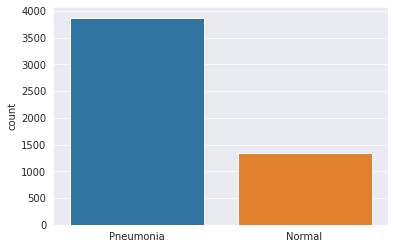

In [4]:
# explore the data

print('train data infos:\n')

tmp = []
for i in train_data:
    if(i[1] == 0):
        tmp.append("Pneumonia")
    else:
        tmp.append("Normal")
sns.set_style('darkgrid')
sns.countplot(tmp)  

In [5]:
print("""
!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.
!!!
!!!
We will apply data augmentation methods to increase the number of training images
!!!
""")


!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.
!!!
!!!
We will apply data augmentation methods to increase the number of training images
!!!



Text(0.5, 1.0, '1')

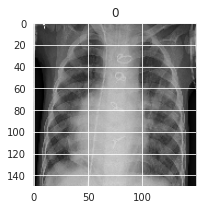

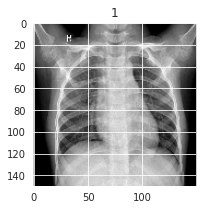

In [6]:
# display some sample images
plt.figure(figsize=(3,3))
plt.imshow(train_data[10][0], cmap='gray') #label 0 = pneumonia
plt.title(train_data[10][1])

plt.figure(figsize=(3,3))
plt.imshow(train_data[-1][0], cmap='gray') #label 1 = normal
plt.title(train_data[-1][1])

## Preprocessing

In [ ]:
#train_data[0][1] #label
#train_data[0][0] #image
#train_data[0][0][0] #prima riga della matrice dell'immagine
#train_data[0] #image+label
#train_data[:][1]

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for img, lbl in train_data:
    img_tmp = img.astype('float32')
    x_train.append(img_tmp)
    y_train.append(lbl)

for img, lbl in test_data:
    img_tmp = img.astype('float32')
    x_test.append(img_tmp)
    y_test.append(lbl)
    
for img, lbl in val_data:
    img_tmp = img.astype('float32')
    x_val.append(img_tmp)
    y_val.append(lbl)

#normalize data
x_train = np.array(x_train)/255
x_train = x_train.reshape(-1, image_size, image_size, 1) #numpy si occupa di settare la prima dimensione (= numero di elementi nel training set )
y_train = np.array(y_train)

x_val = np.array(x_val)/255
x_val = x_val.reshape(-1, image_size, image_size, 1)
y_val = np.array(y_val)

x_test = np.array(x_test)/255
x_test = x_test.reshape(-1, image_size, image_size, 1)
y_test = np.array(y_test)

In [8]:
#number of samples in all the three sets
print('SIZES')
print('Training set: {}\nValidation set: {}\nTest set: {}'.format(x_train.shape[0], x_val.shape[0], x_test.shape[0]))

SIZES
Training set: 5216
Validation set: 16
Test set: 624


### Data Augmentation

In [9]:
# it would be better to use the tf.keras.layers.preprocessing for image
# augmentation for new code, as done before (and maybe use this image 
# datagenerator only to increase the number of
# val images with datagen.flow in the .fit()) ----> worse

datagen = ImageDataGenerator(  
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
    )
#datagen.fit(x_train)

In [10]:
learning_rate_adaption = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

### Tensorflow Model
Simple CNN with a convolutional layer, a maxpool layer, a dense layer of 100 neurons and a single terminal neuron

In [11]:
#model definition
model = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 1)),
              tf.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.Dropout(0.1),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #rmsprop uses adaptive learning rate, learning rate is not an hyperparameter

#print model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

## Training

In [12]:
pneumonia_tot = (y_train == 0).sum() + (y_val == 0).sum() + (y_test == 0).sum()
normal_tot = (y_train == 1).sum() + (y_val == 1).sum() + (y_test == 1).sum()
total_training = (y_train == 0).sum() + (y_train == 1).sum()

weight_for_pneumonia = (1 / pneumonia_tot) * (total_training / 2.0)
weight_for_normal = (1 / normal_tot) * (total_training / 2.0)
print(weight_for_pneumonia)
print(weight_for_normal)

#setting weights for focusing the training phase on the least represented class of images 
class_weights = {0: weight_for_pneumonia, 1: weight_for_normal}


0.6103440205944302
1.647504737839545


Model training

In [13]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                epochs=30, validation_data=datagen.flow(x_val, y_val),
                                class_weight = class_weights, callbacks=[learning_rate_adaption]) 

Epoch 1/30
163/163 [==============================] - 25s 68ms/step - loss: 0.6129 - accuracy: 0.8096 - val_loss: 87.6101 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 11s 67ms/step - loss: 0.3455 - accuracy: 0.8518 - val_loss: 90.4225 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 11s 68ms/step - loss: 0.2993 - accuracy: 0.8865 - val_loss: 3.2246 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 11s 68ms/step - loss: 0.2804 - accuracy: 0.8865 - val_loss: 1.9618 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.8972
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 11s 67ms/step - loss: 0.2329 - accuracy: 0.8972 - val_loss: 91.8114 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/30
163/163 [==============================]

In [14]:
print('Model:\n')
scores = model.evaluate(x_test, y_test, verbose=2)
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("----------------------------")


Model:

20/20 - 1s - loss: 0.4140 - accuracy: 0.8285 - 698ms/epoch - 35ms/step
 accuracy: 82.85%
----------------------------


## Performace

In [15]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
  
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

### Model Plot

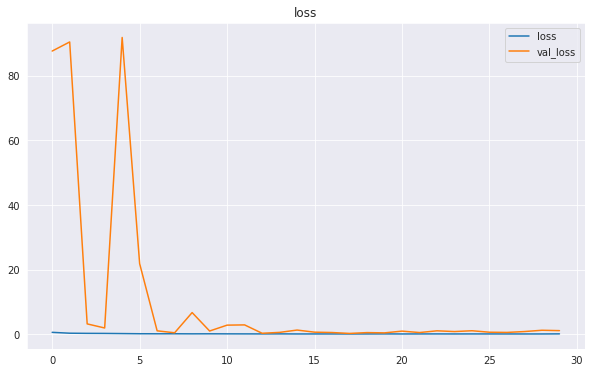

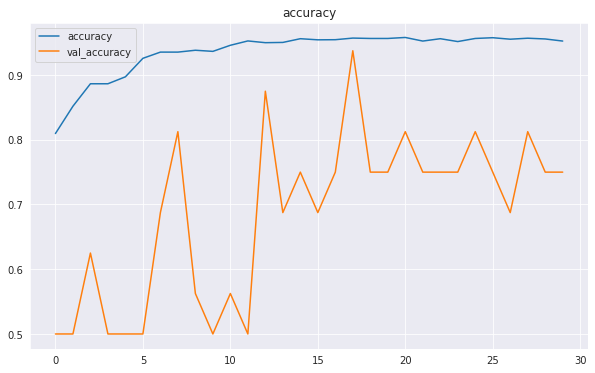

In [16]:
plot_loss(history)
plot_accuracy(history)

## Data Analysis

Confusion Matrix

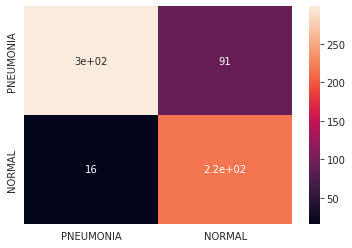

In [39]:
#get predicted labels
p = model.predict(x_test)
#manage to get classes 0 and 1
predictions = [1 if p[i] > 0.5 else 0 for i in range(p.shape[0])]
predictions = np.array(predictions)
#print(prediction)

#confusion matrix
matrix = tf.math.confusion_matrix(y_test, predictions, num_classes=2)
#print(matrix)
sns.heatmap(matrix, xticklabels=('PNEUMONIA', 'NORMAL'), yticklabels=('PNEUMONIA', 'NORMAL'), annot=True)

ROC Curve Plot

In [36]:
#plot function
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()

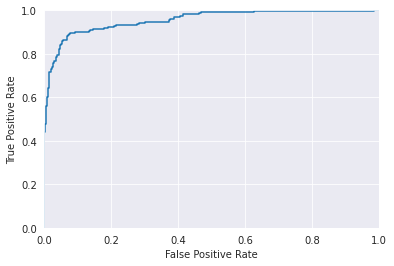

In [40]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, p)
plot_roc_curve(fpr,tpr) 